In [2]:
import requests
from bs4 import BeautifulSoup
import html
from time import sleep
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

def obsahuje_klucove_slova(nazov_pozicie):
    klucove_slova = ['anal', 'data', 'python', 'vedec']
    return any(klucove_slovo in nazov_pozicie.lower() for klucove_slovo in klucove_slova)

def ocisti_a_rozdel_plat(platny_rozsah_text):
    ocisteny_plat = ''.join(c for c in str(platny_rozsah_text) if c.isdigit())
    if len(ocisteny_plat) == 10:
        return int(ocisteny_plat[:5]), int(ocisteny_plat[5:])
    elif len(ocisteny_plat) == 12: 
        return int(ocisteny_plat[:6]), int(ocisteny_plat[6:])
    elif len(ocisteny_plat) == 11: 
        return int(ocisteny_plat[:5]), int(ocisteny_plat[5:])
    else:
        return int(ocisteny_plat), 0

def ziskaj_platy(zakladna_url, rozsah_stran):
    hlavicky = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    platy_zoznam = []

    for cislo_strany in range(1, rozsah_stran + 1):  # Začnite od strany 1
        aktualna_url = f"{zakladna_url}&page={cislo_strany}"

        odpoved = requests.get(aktualna_url, headers=hlavicky)

        if odpoved.status_code == 200:
            pole = BeautifulSoup(odpoved.text, 'html.parser')
            pracovne_inzeraty = pole.select('article')

            for pracovny_inzerat in pracovne_inzeraty:
                odkaz_pozicie = pracovny_inzerat.select_one('header h2 a')
                if not odkaz_pozicie:
                    continue

                nazov_pozicie = odkaz_pozicie.get_text(strip=True)
                odkaz_prace = odkaz_pozicie['href']

                if not obsahuje_klucove_slova(nazov_pozicie):
                    print(f"Ignorovanie práce - Pozícia: {nazov_pozicie} (Neobsahuje relevantné kľúčové slová)")
                    continue

                znacka_platu = pracovny_inzerat.select_one('div span.Tag.Tag--success.Tag--small.Tag--subtle')
                if znacka_platu:
                    text_rozsahu_platu = znacka_platu.get_text(strip=True)
                    dekodovany_rozsah_platu = html.unescape(text_rozsahu_platu)
                    ocisteny_plat = ocisti_a_rozdel_plat(dekodovany_rozsah_platu)

                    print(f"Rozsah platu pre pozíciu '{nazov_pozicie}' (Strana {cislo_strany}): {dekodovany_rozsah_platu}")

            
                    platy_zoznam.append({'Pozícia': nazov_pozicie, 'Rozsah platu': ocisteny_plat, 'Odkaz na prácu': odkaz_prace, 'Strana': cislo_strany})
    return platy_zoznam

#zakladna URL+ pcet stranok
zakladna_url = "https://beta.www.jobs.cz/prace/?q%5B%5D=analytik"
rozsah_stran_na_analyzu = 42


platy_zoznam = ziskaj_platy(zakladna_url, rozsah_stran_na_analyzu)


platy_df = pd.DataFrame(platy_zoznam)


platy_df[['Najnižší plat', 'Najvyšší plat']] = pd.DataFrame(platy_df['Rozsah platu'].tolist(), index=platy_df.index)

# hodnoty 0 v Najvyšší pla == 'Najnižší plat'
platy_df.loc[platy_df['Najvyšší plat'] == 0, 'Najvyšší plat'] = platy_df['Najnižší plat']

#nový stĺpec pre priemernej hodnoty
platy_df['Priemerný plat'] = platy_df[['Najnižší plat', 'Najvyšší plat']].mean(axis=1)

#prca s najvyšším a najnižším platom
najvyssie_platena_praca = platy_df.loc[platy_df['Najvyšší plat'].idxmax()]
najnizsie_platena_praca = platy_df.loc[platy_df['Najnižší plat'].idxmin()]

print(f"\nNajvyššie platená práca:\n{najvyssie_platena_praca}")
print(f"\nNajnižšie platená práca:\n{najnizsie_platena_praca}")

# Dodatečné statistiky
statistiky_df = platy_df[['Najvyšší plat', 'Priemerný plat']].describe().transpose()

statistiky_df['Průměrný Plat Celkem'] = platy_df['Priemerný plat'].sum()

statistiky_df['Počet'] = platy_df.shape[0]


Ignorovanie práce - Pozícia: Interní auditor/ka (Neobsahuje relevantné kľúčové slová)
Ignorovanie práce - Pozícia: Product Designer / UX Designer pro zadávání pracovních inzerátů – třeba na Jobs.cz (Neobsahuje relevantné kľúčové slová)
Ignorovanie práce - Pozícia: Senior Risk Manager (Neobsahuje relevantné kľúčové slová)
Ignorovanie práce - Pozícia: Obchodník v K&L Rock! (Neobsahuje relevantné kľúčové slová)
Rozsah platu pre pozíciu 'IT/Business Analytik/čka' (Strana 1): 55 000 ‍–‍ 90 000 Kč
Rozsah platu pre pozíciu 'IT Analytik Medior/Senior' (Strana 1): 55 000 ‍–‍ 97 000 Kč
Rozsah platu pre pozíciu 'SW architekt / analytik - rozjíždímě projekty! (až 100.000 Kč)' (Strana 2): 50 000 ‍–‍ 100 000 Kč
Rozsah platu pre pozíciu 'Softwarový Analytik - UML, EA (až 100.000 Kč)' (Strana 2): 70 000 ‍–‍ 100 000 Kč
Rozsah platu pre pozíciu 'IT/Business Analyst' (Strana 2): 70 000 ‍–‍ 140 000 Kč
Rozsah platu pre pozíciu 'Junior IT Analytik - Praha Anděl' (Strana 2): 45 000 ‍–‍ 50 000 Kč
Rozsah platu


Najvyššie platená práca:
Pozícia                                         Integrační Analytik
Rozsah platu                                       (140000, 180000)
Odkaz na prácu    https://beta.www.jobs.cz/rpd/1635039447/?searc...
Strana                                                           15
Najnižší plat                                              140000.0
Najvyšší plat                                              180000.0
Priemerný plat                                             160000.0
Name: 61, dtype: object

Najnižšie platená práca:
Pozícia           PŘÍRODOVĚDNÍ ANALYTIK DIAGNOSTIK (Ž/M) zkrácen...
Rozsah platu                                         (21280, 34696)
Odkaz na prácu    https://beta.www.jobs.cz/rpd/2000099688/?searc...
Strana                                                           13
Najnižší plat                                               21280.0
Najvyšší plat                                               34696.0
Priemerný plat                          

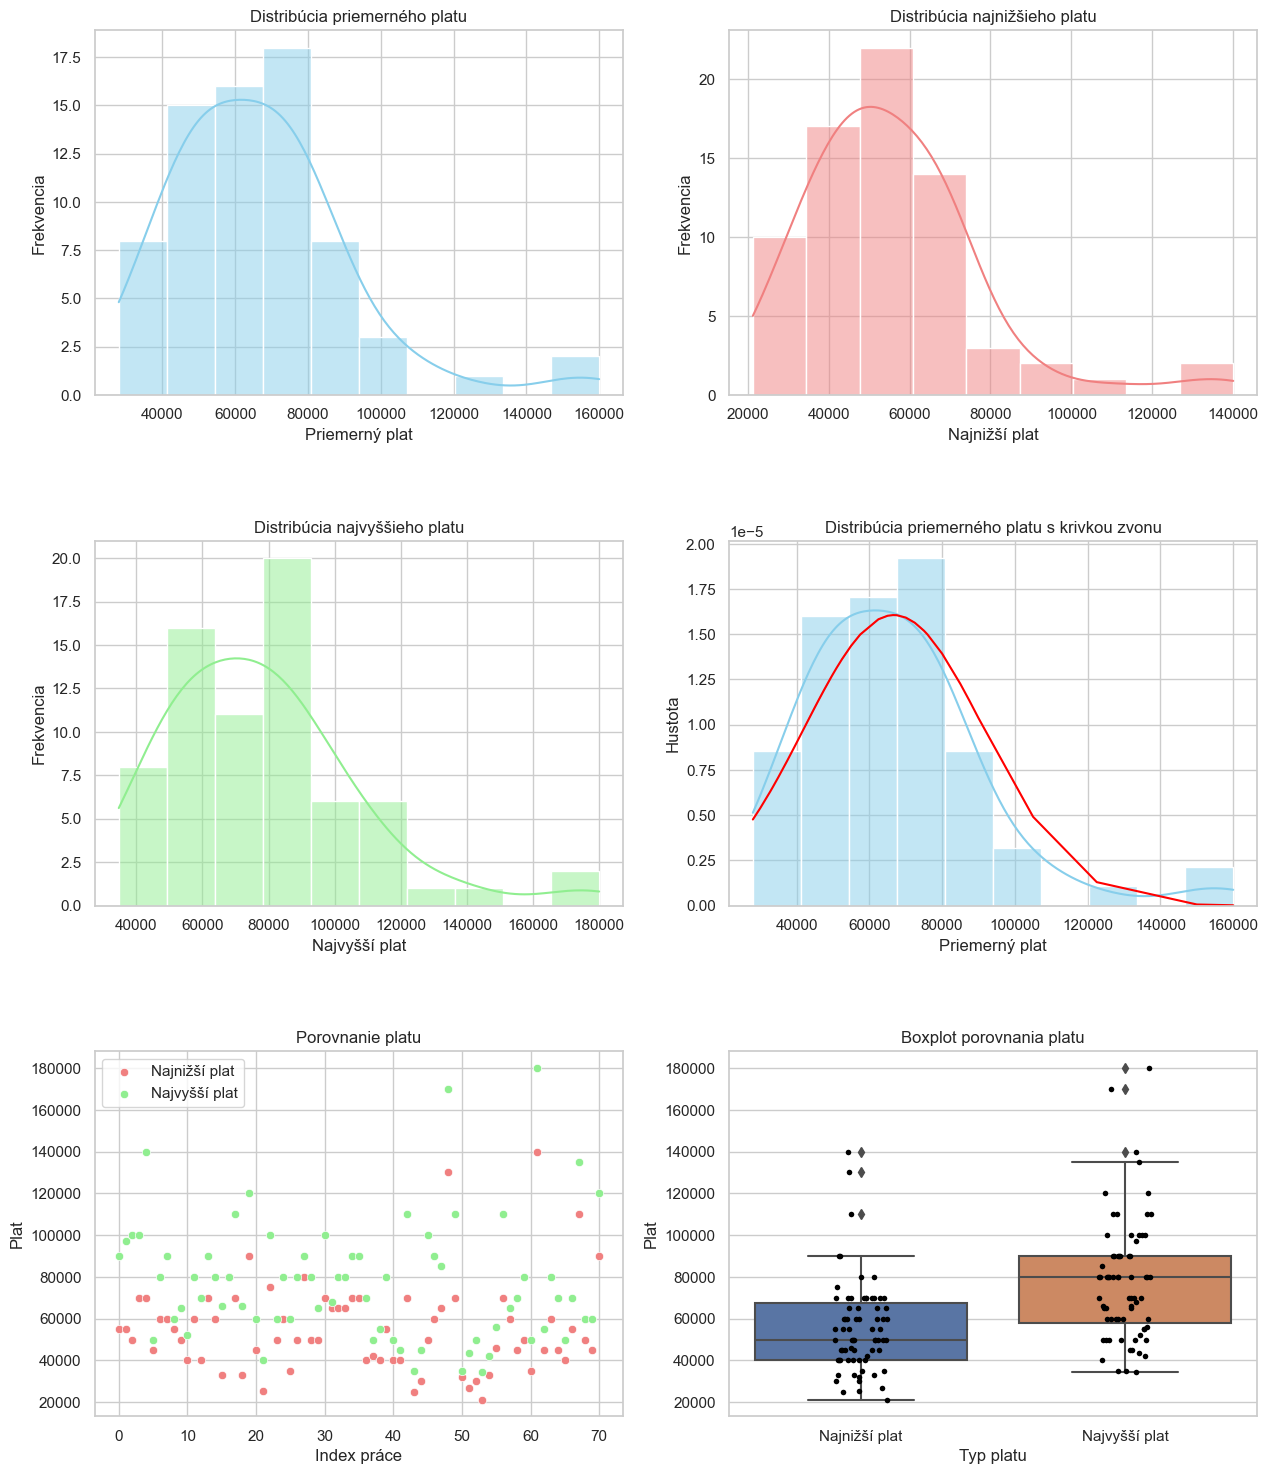

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

#nový stĺpec pre priemernej hodnoty
platy_df_no_zeros['Priemerný plat'] = platy_df_no_zeros[['Najnižší plat', 'Najvyšší plat']].mean(axis=1)

#prca s najvyšším a najnižším platom
najvyssie_platena_praca = platy_df_no_zeros.loc[platy_df_no_zeros['Najvyšší plat'].idxmax()]
najnizsie_platena_praca = platy_df_no_zeros.loc[platy_df_no_zeros['Najnižší plat'].idxmin()]

print(f"\nNajvyššie platená práca:\n{najvyssie_platena_praca}")
print(f"\nNajnižšie platená práca:\n{najnizsie_platena_praca}")

sns.set(style="whitegrid")

#obrázok s viacerými podgrafmi
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
fig.subplots_adjust(hspace=0.4)

# Graf distribúcie priemerného platu
sns.histplot(platy_df_no_zeros['Priemerný plat'], kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distribúcia priemerného platu')
axes[0, 0].set_xlabel('Priemerný plat')
axes[0, 0].set_ylabel('Frekvencia')

# Graf distribúcie najnižšieho platu
sns.histplot(platy_df_no_zeros['Najnižší plat'], kde=True, color='lightcoral', ax=axes[0, 1])
axes[0, 1].set_title('Distribúcia najnižšieho platu')
axes[0, 1].set_xlabel('Najnižší plat')
axes[0, 1].set_ylabel('Frekvencia')

# Graf distribúcie najvyššieho platu
sns.histplot(platy_df_no_zeros['Najvyšší plat'], kde=True, color='lightgreen', ax=axes[1, 0])
axes[1, 0].set_title('Distribúcia najvyššieho platu')
axes[1, 0].set_xlabel('Najvyšší plat')
axes[1, 0].set_ylabel('Frekvencia')

# Graf zvonovej krivky pre priemerný plat
sns.histplot(platy_df_no_zeros['Priemerný plat'], kde=True, color='skyblue', ax=axes[1, 1], stat='density')
sns.lineplot(x=platy_df_no_zeros['Priemerný plat'], y=norm.pdf(platy_df_no_zeros['Priemerný plat'], platy_df_no_zeros['Priemerný plat'].mean(), platy_df_no_zeros['Priemerný plat'].std()), color='red', ax=axes[1, 1])
axes[1, 1].set_title('Distribúcia priemerného platu s krivkou zvonu')
axes[1, 1].set_xlabel('Priemerný plat')
axes[1, 1].set_ylabel('Hustota')

# Graf porovnania platu
sns.scatterplot(x=platy_df_no_zeros.index, y=platy_df_no_zeros['Najnižší plat'], color='lightcoral', label='Najnižší plat', ax=axes[2, 0])
sns.scatterplot(x=platy_df_no_zeros.index, y=platy_df_no_zeros['Najvyšší plat'], color='lightgreen', label='Najvyšší plat', ax=axes[2, 0])
axes[2, 0].set_title('Porovnanie platu')
axes[2, 0].set_xlabel('Index práce')
axes[2, 0].set_ylabel('Plat')
axes[2, 0].legend()

# Graf boxplotu pre porovnanie platu
sns.boxplot(x='variable', y='value', data=pd.melt(platy_df_no_zeros[['Najnižší plat', 'Najvyšší plat']]), ax=axes[2, 1])
axes[2, 1].set_title('Boxplot porovnania platu')
axes[2, 1].set_xlabel('Typ platu')
axes[2, 1].set_ylabel('Plat')

# kvartily k boxplotu
sns.stripplot(x='variable', y='value', data=pd.melt(platy_df_no_zeros[['Najnižší plat', 'Najvyšší plat']]), color='black', size=4, jitter=True, ax=axes[2, 1])

# Zobrazenie štatistík
print("\nInformácie o štatistikách:")
print(platy_df_no_zeros[['Najnižší plat', 'Najvyšší plat', 'Priemerný plat']].describe())

plt.show()
